In [2]:
import os
import glob
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

import settings
DATA_RESULTS = os.path.join(settings.DATA_PATH, "Results") 

In [3]:
# temp = pd.read_csv(DATA_RESULTS + "/Model_volume/final_mixed.csv", header=None)
# # temp = temp.drop(columns=[0])
# # temp.to_csv(DATA_RESULTS + "/Model_scalar/final_mixed.csv.cp", index=False, header=False)
# temp
# 
# print(temp.max()[1])
# print(temp.min()[1])
# print(temp.mean()[1])
# print(temp.std()[1])

0.9810810810810808
0.00546448087431694
0.6472435398030967
0.23466686362343114


In [14]:
import collections

clinical = pd.read_csv(settings.DATA_PATH_CLINICAL_PROCESSED)
print(clinical.columns)


# Get the mixed results
def all_results(path, type):
    files = glob.glob(path + f"/fold*/{type}*.csv")
    
    df = pd.read_csv(files[0])
    df.columns
    
    df_list = []
    pred_list = []
    for file in files:
        df = pd.read_csv(file)
        ids = np.concatenate((df['pA'].values, df['pB'].values))
        ids = collections.Counter(ids)
        key, count = ids.most_common(1)[0]
        
        is_censored = not clinical.loc[clinical['id'] == key, 'event'].values[0]
        # if is_censored:
        #     continue
        
        elem_right = len(df[df["labels"] == df["predictions"]])
        elem_count = len(df)
        
        df_list.append(pd.DataFrame({
            "id": [key],
            "right": [elem_right],
            "total": [elem_count],
            "censored": [is_censored]
        }))
        
        pred_list.append(df)
        
    predictions_df: pd.DataFrame = pd.concat(pred_list, ignore_index=True)
        
    results_df: pd.DataFrame = pd.concat(df_list, ignore_index=True)   
    results_df['c-index'] = results_df['right']/results_df['total']
    
    no_cens_results = results_df.loc[~results_df['censored']]
    return (results_df, no_cens_results), predictions_df


# all_c_index(DATA_RESULTS + "/Model_scalar")

results = {
    'volume': all_results(DATA_RESULTS + "/Model_volume", "mixed"),
    'scalar': all_results(DATA_RESULTS + "/Model_scalar", "mixed"),
    'scalar_CV': {
        "mixed": all_results(DATA_RESULTS + "/Model_scalar_4CV", "mixed"),
        "train": all_results(DATA_RESULTS + "/Model_scalar_4CV", "train"),
        "test": all_results(DATA_RESULTS + "/Model_scalar_4CV", "test"),
    }
}

print("Done")

Index(['Unnamed: 0', 'id', 'age', 'sex', 'event', 'time'], dtype='object')


Done


scalar
Index(['censored', 'id', 'right', 'total', 'c-index'], dtype='object')
Count: 294568
Mean: 0.8225101109263735
Median: 0.9336734693877551
Std: 0.23897976309318378
c-index cens 0.7883476820292767
c-index no cens 0.7401436261748224


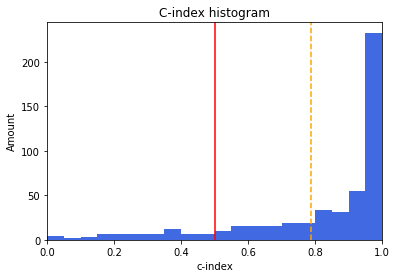

volume
Index(['censored', 'id', 'right', 'total', 'c-index'], dtype='object')
Count: 294568
Mean: 0.6472435398030963
Median: 0.6981519507186859
Std: 0.2346668636234313
c-index cens 0.637761060264523
c-index no cens 0.6232239774081101


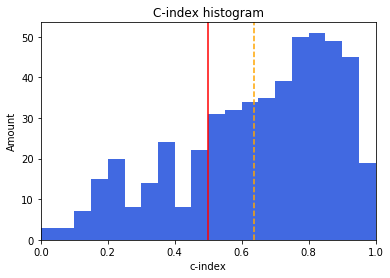

scalar_mixed
Index(['censored', 'id', 'right', 'total', 'c-index'], dtype='object')
Count: 221128
Mean: 0.7890522582030763
Median: 0.7874376022274722
Std: 0.006689076470159852
c-index cens 0.7890316920516623
c-index no cens 0.7890316920516623


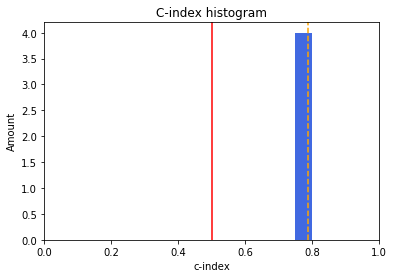

scalar_train
Index(['censored', 'id', 'right', 'total', 'c-index'], dtype='object')
Count: 331288
Mean: 0.9565055030169624
Median: 0.9563402873853972
Std: 0.0032501698090551
c-index cens 0.956503103040255
c-index no cens 0.956503103040255


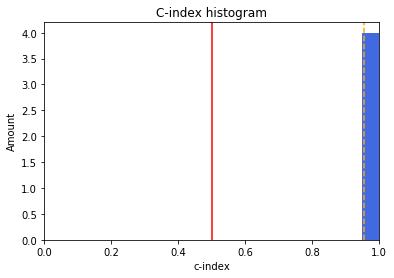

scalar_test
Index(['censored', 'id', 'right', 'total', 'c-index'], dtype='object')
Count: 36720
Mean: 0.62407996071769
Median: 0.620354128803979
Std: 0.009028543797847621
c-index cens 0.6240468409586056
c-index no cens 0.6240468409586056


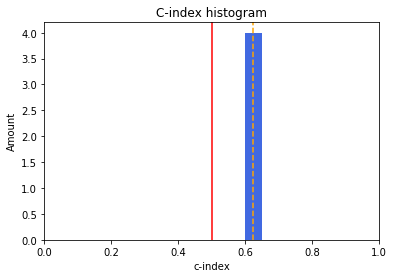

In [23]:
def results_hits(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    print(f"{name}")
    print(cens_results.columns)
    mean = cens_results['c-index'].mean()
    median = cens_results['c-index'].median()
    std = cens_results['c-index'].std()
    print(f"Count: {cens_results['total'].sum()}")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Std: {std}")
    
    all_c_index = cens_results['right'].sum(axis=0)/cens_results['total'].sum(axis=0)
    
    print(f"c-index cens {all_c_index}")
    
    no_cens_c_index = uncens_results['right'].sum(axis=0)/uncens_results['total'].sum(axis=0)
    
    print(f"c-index no cens {no_cens_c_index}")
    
    # n, bins, patches = plt.hist([cens_results['c-index'], uncens_results['c-index']],
    #                             bins=20,
    #                             label=['All', 'Non censored'],
    #                             color=['royalblue', 'orange'])
    
    n, bins, patches = plt.hist([cens_results['c-index']],
                                bins=20,
                                label=['All'],
                                color=['royalblue'],
                                range=(0, 1))
    
    # max_val = max(map(lambda x: max(map(lambda y: y.get_height(), x)), patches))
    max_val = max(map(lambda x: x.get_height(), patches))
    
    plt.axvline(all_c_index, color='orange', linestyle='dashed')
    # plt.text(all_c_index, max_val*.8, 'CI all', rotation=90)
    
    plt.axvline(.5, color='r')
    
    # plt.axvline(no_cens_c_index, color='orange', linestyle='dashed')
    # plt.text(no_cens_c_index, max_val*.8, 'CI no censored', rotation=90)
    
    # plt.axvline(float(mean), color='g', linestyle='dashed')
    # plt.text(float(mean), max_val*.8, "mean", rotation=-90)
    # 
    # plt.axvline(float(median), color='y', linestyle='dashed')
    # plt.text(float(median), max_val*.8, "median", rotation=-90)
    
    plt.xlim(0, 1)
    
    plt.xlabel("c-index")
    plt.ylabel("Amount")
    # plt.legend(loc='upper left')
    plt.title("C-index histogram")
    
    plt.savefig(f"Jupyter/outputs/c-index_{name}.png", dpi=300)
    plt.show()
    


results_hits(*(results['scalar'][0]), "scalar")
results_hits(*(results['volume'][0]), "volume")
results_hits(*(results['scalar_CV']['mixed'][0]), "scalar_mixed")
results_hits(*(results['scalar_CV']['train'][0]), "scalar_train")
results_hits(*(results['scalar_CV']['test'][0]), "scalar_test")

7


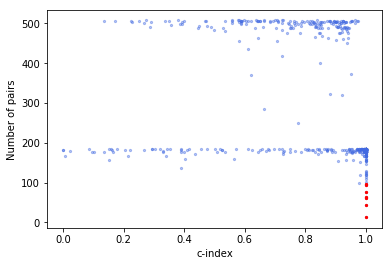

7


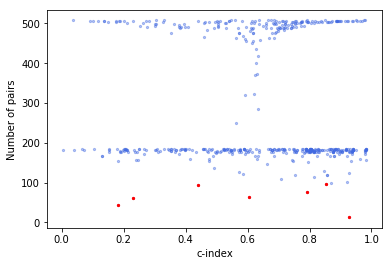

In [32]:
def scatter_results(cens_results: pd.DataFrame, uncens_results: pd.DataFrame, name):
    plt.scatter(cens_results['c-index'], cens_results['total']/2, label="Censored", color="royalblue", s=5, alpha=.4)
    #plt.scatter(uncens_results['c-index'], uncens_results['total'], label="Non censored", color="orange", s=5, alpha=.4)
    
    less_pairs = cens_results.loc[cens_results['total']/2 < 100]
    print(len(less_pairs))
    plt.scatter(less_pairs['c-index'], less_pairs['total']/2, color='red', s=5)
    
    # plt.legend(loc='lower left')
    plt.xlabel("c-index")
    plt.ylabel("Number of pairs")
    
    plt.savefig(f"Jupyter/outputs/scatter_{name}.png", dpi=300)
    plt.show()


scatter_results(*(results['scalar'][0]), 'scalar')
scatter_results(*(results['volume'][0]), 'volume')


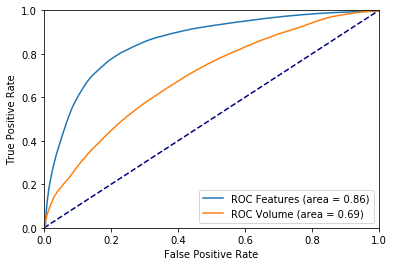

In [55]:

def roc_plot(models: List[Tuple[str, pd.DataFrame]]):
    plt.plot([0, 1], [0, 1], color='navy', linestyle='dashed')
    for name, predictions in models:
        fpr, tpr, _ = roc_curve(predictions['labels'], predictions['probabilities'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"ROC {name} (area = {roc_auc:.2})")
        
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    plt.show()


roc_plot([('Features', results['scalar'][1]), ('Volume', results['volume'][1])])

In [14]:
import math

tasks = 509
workers = 10

length = int(math.ceil(509/workers))
# length = 509 // 41
print(length, length*workers, length*workers - tasks)
limit = tasks - (length - 1)*workers
print("Limit: ", limit)
print("-----------------")

prev_end = 0
for i in range(0, workers):
    task_begin = prev_end
    task_end = task_begin + length - (0 if i < limit else 1)
    task_end = min(task_end, tasks)
        
    prev_end = task_end
        
    # task_end = (i + 1)*length if i + 1 != task_count else tasks - 1
    print(task_begin, task_end - 1, task_end - task_begin)